In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from time import time

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
PATH = 'C:\\Users\\josep\\OneDrive\\Desktop\\Capstone\\Jupyter\\Dataset\\'
Dataset = pd.read_csv(PATH + 'csv_preprocessed.csv')

# Dataset = pd.read_csv('/scratch/vrames25/NIDS/datasets/csv_preprocessed.csv')

In [4]:
data = Dataset[["SrcWin", "DstWin", "dHops", "dTtl", "TotBytes", "SrcBytes", "sMeanPktSz", "DstGap", "SrcGap", "dTos", "DstTCPBase", "SrcTCPBase", "TcpRtt", "Proto_udp", "DstBytes", "AckDat" , "dMeanPktSz", "Proto_tcp", "SynAck", "Load", "Rate", "DstPkts", "SrcLoad", "Dur", "SrcRate"]]

In [5]:
def concat_column(dataset, column_name):
  concat_column_data = pd.concat([dataset, Dataset[column_name]], axis = 1)
  return concat_column_data

data = concat_column(data, "Attack Type")

In [6]:
# Segregate features and labels into separate variables
X_train, X_test, y_train, y_test = train_test_split(data.loc[:, data.columns != 'Attack Type'], data['Attack Type'],
                                                    stratify=data['Attack Type'],
                                                    test_size=0.15)

X_train = pd.DataFrame(X_train, columns=data.columns.to_list()[:-1])
X_test = pd.DataFrame(X_test, columns=data.columns.to_list()[:-1])
y_train = pd.DataFrame(y_train, columns=['Attack Type'])
y_test = pd.DataFrame(y_test, columns=['Attack Type'])

print("Training dataset size:", X_train.shape)
print("Testing dataset size:", X_test.shape)
print("Training target size:", y_train.shape)
print("Testing target size:", y_test.shape)

Training dataset size: (1033323, 25)
Testing dataset size: (182352, 25)
Training target size: (1033323, 1)
Testing target size: (182352, 1)


In [7]:
def get_pca_df(dataset, no_of_components):
  pca = PCA(n_components=no_of_components)
  Principal_components=pca.fit_transform(dataset)
  column_names = ["PC "+str(i) for i in range(1, no_of_components+1)]
  pca_df = pd.DataFrame(data = Principal_components, columns = column_names)
  return pca_df, pca

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
Y = data['Attack Type']
X_train, pca = get_pca_df(X_train, 15)

start_time = time()
for train_index, test_index in skf.split(X_train, y_train):
    X1_train, X1_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y1_train, y1_test = y_train.iloc[train_index], y_train.iloc[test_index]

    # Initialize SVC
    svc_model = SVC(kernel='rbf', random_state=42)  # You can choose different kernels like 'rbf', 'poly', etc.

    # Train the model
    svc_model.fit(X1_train, y1_train)
    # Predict on the test set
    y_pred = svc_model.predict(X1_test)

    # Calculate evaluation metrics and store them
    accuracy_scores.append(accuracy_score(y1_test, y_pred))
    precision_scores.append(precision_score(y1_test, y_pred, average='weighted'))
    recall_scores.append(recall_score(y1_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y1_test, y_pred, average='weighted'))

end_time = time()

In [10]:
print(f' Train start: {start_time}')
print(f' Train end: {end_time}')
print(f' Training time: {end_time - start_time} seconds\n')

 Train start: 1713817797.1204462
 Train end: 1713833149.0594692
 Training time: 15351.939023017883 seconds



In [11]:
print(accuracy_scores)

[0.9921902595988678, 0.9922096145936661, 0.9921321946144727, 0.99219989935354, 0.9921418340881818]


In [12]:
# Predictions
prediction_start_time = time()
x_test = pca.transform(X_test)
y_pred_SVC = svc_model.predict(x_test)
prediction_end_time = time()

In [13]:
print(f' Prediction start: {prediction_start_time}')
print(f' Prediction end: {prediction_end_time}')
print(f' Prediction time: {prediction_end_time - prediction_start_time} seconds\n')

 Prediction start: 1713833149.1327345
 Prediction end: 1713833599.9388928
 Prediction time: 450.8061583042145 seconds



In [14]:
# Compute and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_SVC)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[71629     0     0     0     0     0     0     0     0]
 [    1 21021     0     0     0    98     2     0     0]
 [    0     0   173     0     0     0     0     0     0]
 [    0     0     0  1254   203     1     0     0     0]
 [    0     0     5     3  2997     0     0     0     1]
 [    0  1102     0     6     9  9833    19     0     0]
 [    0     0     1     0     2     0  3005     0     0]
 [    0     0     0     0     0     0     0 68601     0]
 [    0     0     1     0     3     0     0     0  2382]]


In [15]:
le_name_mapping = {'Benign': 0, 'HTTPFlood': 1, 'ICMPFlood': 2, 'SYNFlood': 3, 'SYNScan': 4, 'SlowrateDoS': 5, 'TCPConnectScan': 6, 'UDPFlood': 7, 'UDPScan': 8}

In [16]:
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred_SVC)

In [17]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = le_name_mapping.keys(),
                     columns = le_name_mapping.keys())

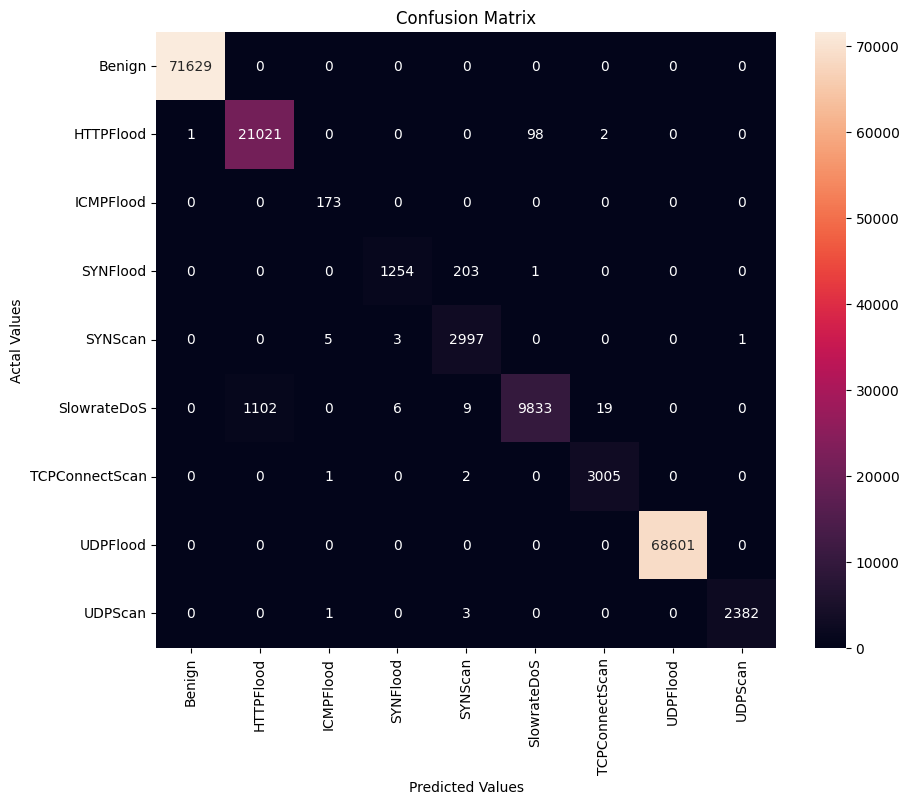

In [18]:
#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.savefig('confusion_matrix_svm_multi.png')

In [19]:
accuracy = accuracy_score(y_test, y_pred_SVC)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9920099587610774


In [20]:
precision = precision_score(y_test, y_pred_SVC, average='weighted') # Use 'binary' for binary classification
print(f'Precision: {precision}')

Precision: 0.9922982777343388


In [21]:
recall = recall_score(y_test, y_pred_SVC, average='weighted') # Use 'binary' for binary classification
print(f'Recall: {recall}')

Recall: 0.9920099587610774


In [22]:
f1 = f1_score(y_test, y_pred_SVC, average='weighted') # Use 'binary' for binary classification
print(f'F1 Score: {f1}')

F1 Score: 0.9918977360709577


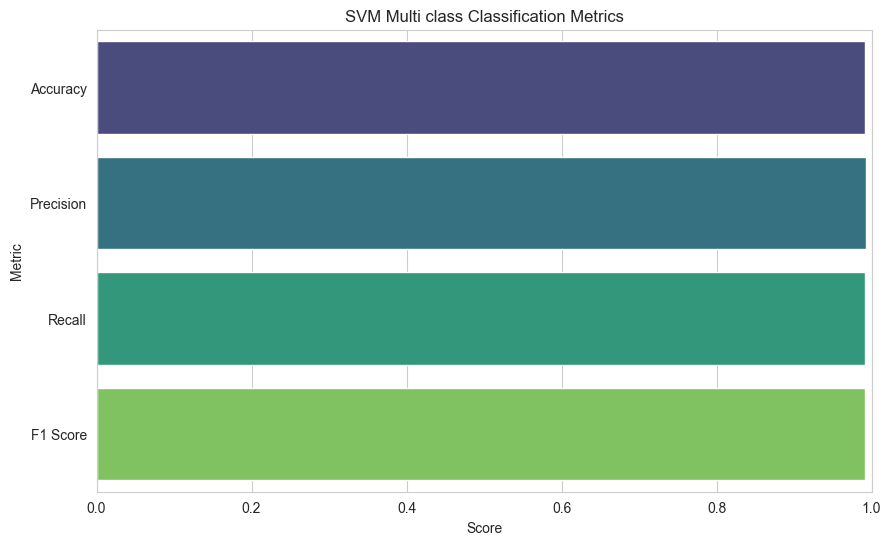

In [23]:
# Assuming metrics are stored in these variables
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    # 'ROC-AUC': roc_auc  # Uncomment if ROC-AUC is applicable and calculated
}

# Convert dictionary to lists for plotting
metric_names = list(metrics.keys())
metric_values = [metrics[metric] for metric in metric_names]

# Create bar plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=metric_values, y=metric_names, palette="viridis")

plt.xlabel('Score')
plt.ylabel('Metric')
plt.title('SVM Multi class Classification Metrics')
plt.xlim(0, 1)  # Assuming the scores are between 0 and 1
plt.savefig('svm_multi_class_metrics.png')